## TP2: avec les photos like/dislike

In [1]:
import pandas as pd

df = pd.read_csv("../../MachineLearning/projet_photo/data_x_y_full_image.csv")
n_photos = len(df.index)
img_rows = 100
img_cols = 100
n_channels = 3
photo_path = "../../MachineLearning/projet_photo/thumbs_100"
print("photos:", n_photos)

photos: 3550


In [2]:
df.head()

,Unnamed: 0,0,y,pseudos
0,0,769ca1d3-77be-45da-b419-a14872961250.jpeg,like,tim
1,1,d173455b-d36d-4cb0-8c39-c4ac274534bb.jpg,dislike,tim
2,2,20d21cc5-48f2-4bf4-a688-70154746d3a8.jpg,like,tim
3,3,88bcbeef-c4e5-4fb8-9b24-bd3a9144a491.jpg,like,tim
4,4,b03bfc54-97e5-470d-8819-5b93593ceb68.jpg,like,tim


In [58]:
import os
import numpy as np
from PIL import Image

for i_img, info in enumerate(df.values.tolist()):
    if i_img == 1565:
        img_file_name = info[1]
        img_path = os.path.join(photo_path, img_file_name)
        # on lit les données de l'image
        img = Image.open(img_path)
        img_array = np.array(img)

In [22]:
import os
import numpy as np
from PIL import Image


X_list_ok = []
Y_list_ok = []

for i_img, info in enumerate(df.values.tolist()):
    img_file_name = info[1]
    img_path = os.path.join(photo_path, img_file_name)
    # on lit les données de l'image
    img = Image.open(img_path)
    # on récupére en matrice numpy les trois canaux
    try:
        # on convertit l'image en numpy array
        img_array = np.array(img)
        if img_array.shape == (100,100,3):
            # on remplit les données d'entrée
            # X[i_img, ...] = img_array
            X_list_ok.append(img_array / 255.)
            # on remplit les données de sortie
            y = None
            if info[2] == "like":
                y = 1
            else:
                y = 0
            Y_list_ok.append(y)
    except Exception as e:
        print("pb", str(e))
print("OK", len(Y_list_ok))


OK 3538


In [23]:
# on construit l'entrée X
n_photos_ok = len(Y_list_ok)
X = np.empty(shape=(n_photos_ok, img_rows, img_cols, 3), dtype=float)
Y = np.empty(shape=(n_photos_ok, 1), dtype=int)

for i, (x,y) in enumerate(zip(X_list_ok, Y_list_ok)):
    X[i, :,:,:] = x
    Y[i] = y
del X_list_ok
del Y_list_ok

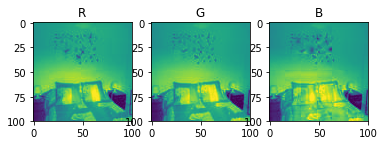

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,3,1)
plt.imshow(X[0,:,:,0])
plt.title("R")
plt.subplot(1,3,2)
plt.imshow(X[0,:,:,1])
plt.title("G")
plt.subplot(1,3,3)
plt.imshow(X[0,:,:,2])
plt.title("B")
plt.show()

In [24]:
print(Y[0], X[0, :, :, 0])

[1] [[0.58039216 0.58039216 0.58431373 ... 0.59607843 0.59607843 0.59215686]
 [0.5254902  0.5254902  0.52941176 ... 0.54117647 0.5372549  0.53333333]
 [0.50588235 0.50588235 0.50980392 ... 0.51764706 0.51372549 0.50980392]
 ...
 [0.03921569 0.04313725 0.05490196 ... 0.69803922 0.69411765 0.69019608]
 [0.04705882 0.05098039 0.05882353 ... 0.70980392 0.70196078 0.69803922]
 [0.05098039 0.05490196 0.0627451  ... 0.71372549 0.70588235 0.70196078]]


In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten

data_format="channels_last"
input_shape=(img_rows, img_cols, n_channels)
num_classes=1

# KERAS CNN: 
input_layer = Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     input_shape=input_shape, 
                     data_format=data_format, 
                     padding="same",
                     activation="relu")
model = Sequential()
model.add(input_layer)
# 100x100
model.add(MaxPooling2D((2,2)))
# 50x50
model.add(Conv2D(32, (3,3), padding="same"))
model.add(MaxPooling2D((2,2)))
# 25x25
model.add(Conv2D(32, (3,3), padding="same"))
model.add(MaxPooling2D((5,5)))
# 5x5
model.add(Flatten())
# model.add(Dense(4, activation="relu"))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
__________

In [26]:
print("start compile")
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=adam,
              metrics=['accuracy'])
print("done")

start compile
done


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    shuffle=True,
    test_size=0.3
)

In [11]:
print(X_train.shape)

(2476, 100, 100, 3)


In [ ]:
print("start fit")
model.fit(X_train, Y_train,
          batch_size=1,
          epochs=5,
          verbose=1,
          validation_data=(X_test, Y_test))
print("done")

start fit
Train on 2476 samples, validate on 1062 samples
Epoch 1/5
2476/2476 [==============================] - 97s 39ms/step - loss: 0.3982 - acc: 0.6018 - val_loss: 0.3663 - val_acc: 0.6337
Epoch 2/5
2476/2476 [==============================] - 100s 40ms/step - loss: 0.3982 - acc: 0.6018 - val_loss: 0.3663 - val_acc: 0.6337
Epoch 3/5
2476/2476 [==============================] - 101s 41ms/step - loss: 0.3982 - acc: 0.6018 - val_loss: 0.3663 - val_acc: 0.6337
Epoch 4/5
2475/2476 [============================>.] - ETA: 0s - loss: 0.3980 - acc: 0.6020

## Visu

In [15]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations


In [ ]:
layer_idx = -1

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
for i in range(2):
    filter_idx = i
    plt.figure()
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0.0, 1.0))
    plt.imshow(img[..., 0])
    plt.title("network perception of %s"%i)
    plt.show()

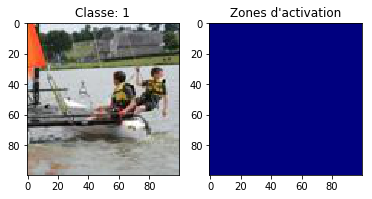

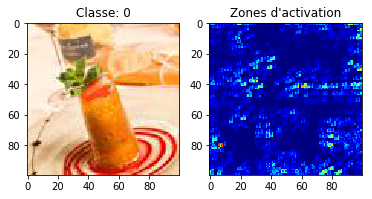

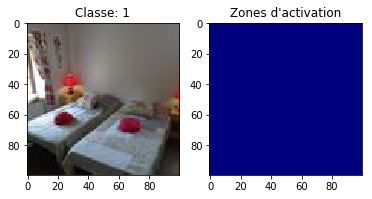

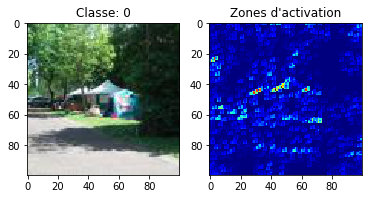

In [20]:
from vis.visualization import visualize_saliency
from vis.utils import utils

# on prend ume image
for sample_index in [1, 100, 200, 300]:
    # sample_index = 1000
    img = X_test[sample_index, :, :, :]
    cls = Y_test[sample_index].argmax()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Classe: %s"%cls)

    # on construit les zones d'attention
    grads = visualize_saliency(
        model, 
        -1, 
        filter_indices=cls, 
        seed_input=img.reshape(1, 100, 100, 3), 
        backprop_modifier="guided"
    )
    # Plot with 'jet' colormap to visualize as a heatmap.
    plt.subplot(1,2,2)
    plt.imshow(grads, cmap='jet')
    plt.title("Zones d'activation")
    plt.show()